Generating realizations of a 2d Gaussian random field $\phi(x)$, with some simple analysis run on the position space results.  Inspired by the [Cosmic Microwave Background (CMB)](https://en.wikipedia.org/wiki/Cosmic_microwave_background); see [my website](https://garrettgoon.com/gaussian-fields/) for more background information.

TODO:

- Extend to higher dimensions
- Some systematic errors seem to still exist w/ theory doing increasingly poorly and over-predicting correlations as `power` increases towards 2.  Need to find/understand, test more

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats as stats
import corner
import time

import scipy.stats as stats
from scipy.optimize import minimize
from scipy.special import gamma


Create a class for generating the power spectrum.  Spectra are characterized by an amplitude and power-law exponent: $\langle \phi(k)\phi(-k)\rangle'=\frac{\texttt{amplitude}}{k^{\texttt{power}}}\equiv P(k)$, corresponding in position space to $\langle \phi(x)\phi(0)\rangle\propto \frac{\texttt{amplitude}}{x^{d-{\texttt{power}}}}\equiv G(x)$ in $d$-dimensions. 

Important parameters:

- `amplitude`: amplitude of spectrum, defined above
- `power`: power-law exponent, defined above
- `dimensions`: number of spatial dimensions (can only use `dimensions`=2, currently)
- `size_exponent`: grid size is 2**`size_exponent`
- `maxlen`: max separation of data points collected when forming binned correlation function
    
Methods: 

- `generate`: generate realization of desired power spectrum, perform simple fit as sanity check
- `spectrum_plot`: visualization of generated spectra
- `hist`: histogram of generated values (should be normally distributed; mostly a sanity check)
- `bin_pair_data`: pair data separated by less than distance `maxlen` and bin to find correlation function. Produce some summary plots, perform simple linear-regression, and compare fit and theory to results.
- `bayes`: simple bayesian/MCMC analysis on `amplitude` and `power` parameters using flat priors
    


In [14]:
class CmbPy():
    def __init__(self, amplitude=1, power=1.75, size_exponent=3, dimensions=2):
        self.amplitude = amplitude
        self.power = power
        self.size = int(2**(size_exponent))
        self.dimensions = dimensions
        # writing P(k)=amplitude/k^{power}, then corresponding position-space correlator is
        # G(x)=x_amplitude/x^{dims-power} with x_amplitude as below:
        self.x_amplitude = 1 / (
            np.pi * 2**
            self.power) * self.amplitude * gamma(1 - (self.power / 2)) / gamma(
                self.power / 2) * (2 * np.pi / self.size)**(self.power)
        # the final (2*np.pi/self.size)**(self.power) factor comes from being careful in passing from continuous to discrete

    def _theory_xspace(self, theta, x):
        amplitude, power = theta
        """
            The theoretical position-space correlator, given the model parameters. 
            Only valid for 2d right now. Unambiguous for 2>power>.5
            """
        return 1 / (np.pi * 2**power) * amplitude * x**(
            power - 2) * gamma(1 - (power / 2)) / gamma(
                power / 2) * (2 * np.pi / self.size)**(self.power)

    def generate(self):
        """
        generating the spectrum
        """
        # creating a grid w/ each point pulled from std normal
        gaussian_seed = np.random.normal(
            size=[self.size for _ in range(self.dimensions)])
        # fourier transform
        gaussian_seed_fourier = np.fft.fft2(gaussian_seed)
        # numpy's fft algorithm automatically indexes with negative values on right half
        # positive on left half, as desired

        # relevant momenta vectors with desired fft indexing
        # plus the related meshgrid and array of momentum norms
        # we will include 2\pi factors in the power spectrum
        kvector = np.fft.fftfreq(self.size) * self.size
        kgrid = np.meshgrid(kvector, kvector)
        knorms = np.sqrt(kgrid[0]**2 + kgrid[1]**2)

        # create the desired power spectrum with the k=0 divergence regulated to zero
        if self.power > 0:
            knorms[0][0] = np.inf
        power_spectrum = self.amplitude * (1 / knorms**self.power)

        # and its square root
        power_spectrum_sqrt = np.sqrt(power_spectrum)
        # multiply by the transformed white noise to get the realization of the spectrum
        fourier_spectrum = gaussian_seed_fourier * power_spectrum_sqrt

        # create the power spectrum
        # https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/ is useful resource for this
        # create measured power spectrum (recalling to divide by appropriate N's)
        fourier_amplitudes = np.abs(fourier_spectrum)**2 / (self.size)**2
        # flatten out and bin
        fourier_amplitudes_flat = fourier_amplitudes.flatten()
        knorms_flat = knorms.flatten()
        kbins = np.arange(.5, self.size // 2 + 1, 1)
        kvals = 0.5 * (kbins[1:] + kbins[:-1])
        binned_means, _, _ = stats.binned_statistic(knorms_flat,
                                                    fourier_amplitudes_flat,
                                                    statistic='mean',
                                                    bins=kbins)

        # simple linear regression (treating all errors as equal)
        # use abs on binned_means to force positive; a fudge for very low statistics data and testing
        spectrum_lr = stats.linregress(np.log(1 / kvals),
                                       np.log(np.abs(binned_means)))

        def spectrum_lr_fit(k):
            return np.exp(spectrum_lr.intercept) / (k**(spectrum_lr.slope))

        # plotting
        fig, axs = plt.subplots(2)
        x_fit = np.linspace(kvals[0], kvals[-1], num=100)
        y_fit = spectrum_lr_fit(x_fit)
        axs[1].loglog(x_fit,
                      y_fit,
                      linestyle='-',
                      color='r',
                      label='linear-regression')
        axs[0].plot(kvals, binned_means)
        axs[0].set_xlabel('$k$')
        axs[0].set_ylabel('$P(k)$')
        axs[1].loglog(kvals, binned_means)
        axs[1].set_xlabel('$k$')
        axs[1].set_ylabel('$P(k)$')
        axs[1].set_title(
            f'$P^{{fit}}(k)\\approx  {np.exp(spectrum_lr.intercept):.5f}\\cdot k^{{{-1*spectrum_lr.slope:.5f}}} \\quad P^{{theory}}(k)\\approx  {self.amplitude:.5f}\\cdot k^{{{-self.power:.5f}}} $'
        )
        fig.suptitle(
            f'Actual values: (amp,power)=({self.amplitude:.5f},{self.power})')
        plt.tight_layout()
        plt.legend()
        plt.show()

        # transform back and take the real part to get the spectrum
        self.spectrum = np.real(np.fft.ifft2(fourier_spectrum))

        # imaginary parts are from numerical errors; they're very small
        im_to_re_ratio = np.imag(np.fft.ifft2(fourier_spectrum)) / np.real(
            np.fft.ifft2(fourier_spectrum))

        print(
            'Sanity check: ratio of imaginary to real components in generated data:'
        )
        print(
            f'Average ratio: {np.mean(im_to_re_ratio)} Standard dev.: {np.std(im_to_re_ratio)}'
        )

    def spectrum_plot(self):
        """
        plotting the spectrum
        """
        if hasattr(self, 'spectrum'):
            fig, ax = plt.subplots()
            ax.imshow(self.spectrum)
            fig.suptitle('Realization')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            plt.show()
        else:
            print('Run generate to create spectrum first')

    def hist(self):
        """
        histogram of generated values
        """

        if not hasattr(self, 'spectrum'):
            return print('Run generate to create spectrum first')

        data = self.spectrum.flatten()
        std = np.std(data)
        self.std = std
        # plot data
        _, ax = plt.subplots()
        ax.hist(data, bins=100, density=True)
        ax.set_ylabel('counts')
        ax.set_xlabel('$\phi$')
        ax.set_title('Distribution of generated points')
        # plot fit
        x = np.linspace(-5 * std, 5 * std, 100)
        y = stats.norm.pdf(x, 0, std)
        ax.plot(x, y, label=f'Normal(0,{std**2:.5f})')
        plt.legend()
        plt.show()

    def bin_pair_data(self, maxlen=None):
        """
        Collect all independent pairs of data points separated by less than maxlen
        and bin them by distance, rounding to nearest integer. 
        Plot various aspects of data
        """
        # dynamically choosing maxlen, if not specified:
        if maxlen == None:
            maxlen = int(self.size / 10)

        print('Collecting pair data...')

        #put data in array with (dist, phi1*phi2) as entries
        pairs = []
        # bottleneck, use progress counter, timer
        start = time.time()
        prog = 20
        for i in range(self.size):
            if (i + 1) % int(self.size / 5) == 0:
                print(f'{prog}% complete')
                prog += 20
            for j in range(self.size):
                for a in range(i + 1, min(self.size, i + maxlen)):
                    for b in range(j + 1, min(self.size, j + maxlen)):
                        dist = np.sqrt((i - a)**2 + (j - b)**2)
                        pairs.append(
                            (dist, self.spectrum[i][j] * self.spectrum[a][b]))
        print('Data collection time:', f'{time.time()-start:.5f}', 'seconds')
        # compute how many data pairs were analyzed:
        print('Independent data pairs analyzed:', len(pairs))

        pairs_x = [item[0] for item in pairs]
        pairs_y = [item[1] for item in pairs]
        xbins = np.arange(.5, maxlen, 1)
        xvals = 0.5 * (xbins[1:] + xbins[:-1])
        binned_corr, _, _ = stats.binned_statistic(pairs_x,
                                                   pairs_y,
                                                   statistic='mean',
                                                   bins=xbins)
        binned_corr_std, _, _ = stats.binned_statistic(pairs_x,
                                                       pairs_y,
                                                       statistic='std',
                                                       bins=xbins)
        binned_corr_count, _, _ = stats.binned_statistic(pairs_x,
                                                         pairs_y,
                                                         statistic='count',
                                                         bins=xbins)

        # histograms of counts and stds
        fig, axs = plt.subplots(2)
        axs[0].bar(xvals, binned_corr_count)
        axs[0].set_xlabel('x')
        axs[0].set_title('Points per bin')
        axs[1].scatter(xvals, binned_corr_std)
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('$\\sigma$')
        axs[1].set_title('Std. of $\\phi(x)\\phi(0)$ values per bin')
        plt.tight_layout()
        plt.show()

        # simple linear regression (treating all errors as equal)
        # use abs on binned_corr to force positive; a fudge for very low statistics data and testing
        correlator_lr = stats.linregress(np.log(1 / xvals),
                                         np.log(np.abs(binned_corr)))
        # save
        self.lr_fit = {
            'x_amplitude': np.exp(correlator_lr.intercept),
            'power': self.dimensions - correlator_lr.slope
        }

        # fit fn
        def correlator_lr_fit(x):
            return np.exp(correlator_lr.intercept) / (x**(correlator_lr.slope))

        # plotting
        fig, axs = plt.subplots(2)
        # data
        axs[0].errorbar(xvals,
                        binned_corr,
                        yerr=binned_corr_std / np.sqrt(binned_corr_count),
                        marker='.',
                        color='k')
        axs[1].errorbar(xvals,
                        binned_corr,
                        yerr=binned_corr_std / np.sqrt(binned_corr_count),
                        marker='.',
                        color='k')
        # fit
        x_fit = np.linspace(xvals[0], xvals[-1], num=100)
        y_fit = correlator_lr_fit(x_fit)
        axs[0].plot(x_fit,
                    y_fit,
                    linestyle='-',
                    color='r',
                    label='linear-regression')
        axs[1].loglog(x_fit,
                      y_fit,
                      linestyle='-',
                      color='r',
                      label='linear-regression')
        axs[0].plot(xvals, binned_corr)
        axs[0].set_xlabel('$x$')
        axs[0].set_ylabel('$\\langle \\phi(x)\\phi(0)\\rangle\equiv G(x)$')
        axs[1].loglog(xvals, binned_corr)
        axs[1].set_xlabel('$x$')
        axs[1].set_ylabel('$\\langle \\phi(x)\\phi(0)\\rangle\equiv G(x)$')
        # theory
        # plotting theory prediction:
        y_theory = self._theory_xspace((self.amplitude, self.power), x_fit)
        axs[0].plot(x_fit, y_theory, linestyle=':', color='m', label='theory')
        axs[0].plot(x_fit, y_theory, linestyle=':', color='m', label='theory')
        axs[1].loglog(x_fit,
                      y_theory,
                      linestyle=':',
                      color='m',
                      label='theory')

        x_amp = 1 / (np.pi * 2**self.power) * self.amplitude * gamma(
            1 - (self.power / 2)) / gamma(
                self.power / 2) * (2 * np.pi / self.size)**(self.power)
        axs[1].set_title(
            f'$G^{{fit}}(x)\\approx  {np.exp(correlator_lr.intercept):.5f}\\cdot x^{{{-1*correlator_lr.slope:.5f}}} \\quad G^{{theory}}(x)\\approx  {x_amp:.5f}\\cdot x^{{{self.power-self.dimensions:.5f}}} $'
        )
        fig.suptitle(
            f'Actual values: (amp,power)=({self.amplitude:.5f},{self.power:.5f})'
        )
        plt.tight_layout()
        plt.legend()
        plt.show()

        # compute summary statistics: (x,y_bar,std(y_bar))
        data_summary = np.array([[
            xvals[i], binned_corr[i],
            binned_corr_std[i] / np.sqrt(binned_corr_count[i])
        ] for i in range(len(xvals)) if binned_corr_count[i] > 0])

        self.data_summary = data_summary

    def bayes(self, steps=10**4, walkers=2**6):
        """
        bayesian analysis for power-spectrum parameters using binned data
        """

        if not hasattr(self, 'data_summary'):
            return print('Run data_fit first')

        # set flat priors on the amplitude and power over some range covering actual values
        amp_max, power_max = 3 * self.amplitude, 10

        def log_prior(theta):
            amplitude, power = theta
            if 0 < amplitude < amp_max and 0 < power < power_max:
                return 0.0
            return -np.inf

        def log_likelihood(theta, data):
            x, y, sigy = data
            return np.sum(-np.log(sigy) - .5 *
                          (self._theory_xspace(theta, x) - y)**2 / sigy**2)

        # total log-prob needed for MCMC
        def log_posterior(theta, data):
            lp = log_prior(theta)
            if not np.isfinite(lp):
                return -np.inf
            return lp + log_likelihood(theta, data)

        # MCMC setup
        # distribute initial walker positions around position space LR best fits (so as not to cheat)
        initial = np.array([self.lr_fit['x_amplitude'], self.lr_fit['power']])
        pos = initial.T + .1 * np.concatenate(
            (np.random.uniform(-initial[0], initial[0], (walkers, 1)),
             np.random.uniform(-initial[1], initial[1], (walkers, 1))),
            axis=1)
        walkers, dim = pos.shape

        sampler = emcee.EnsembleSampler(walkers,
                                        dim,
                                        log_posterior,
                                        args=[self.data_summary.T])
        sampler.run_mcmc(pos, steps, progress=True)
        samples = sampler.get_chain()

        # plotting chain convergence
        fig, axs = plt.subplots(2)
        for i in range(walkers):
            for j in range(dim):
                axs[j].plot(samples[:, i, j])

        axs[0].set_ylabel('amp')
        axs[1].set_ylabel('power')
        fig.suptitle('Chain convergence')
        plt.show()

        # autocorrelation analysis
        auto_corr = sampler.get_autocorr_time()
        thin_rate = int(np.mean(np.array(auto_corr)) / 2)

        # burn 1/4 of data, then make corner plots
        flat_samples = sampler.get_chain(discard=int(steps / 4),
                                         thin=thin_rate,
                                         flat=True)
        amp_samples, power_samples = flat_samples[:, 0], flat_samples[:, 1]

        fig = corner.corner(flat_samples,
                            labels=['amp', 'power'],
                            truths=[self.amplitude, self.power],
                            truth_color='r')
        fig.suptitle(
            f'Actual values: (amp,power)=({self.amplitude:.5f},{self.power:.5f})'
        )
        plt.show()

Run a realization and analyze.  Choose the amplitude and power randomly.

The momentum space correlator $P(k)=\frac{\texttt{amplitude}}{k^{\texttt{power}}}$ only unambiguously defines a position-space correlator $G(x)$ for $2>{\texttt{power}}>1/2$ (other values require regularization/analytic continuation) and so we restrict to this range ([relevant integral can be found here](https://dlmf.nist.gov/10.22#E43)).

Some parameter choices which run in reasonable time: `size_exponent`=8, `maxlen`=15, `steps`=5000, `walkers`=64.

amplitude: 5.89284 
power: 1.93040


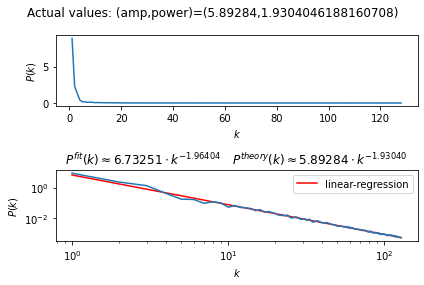

Sanity check: ratio of imaginary to real components in generated data:
Average ratio: 1.766634386821083e-16 Standard dev.: 1.205971051732336e-13


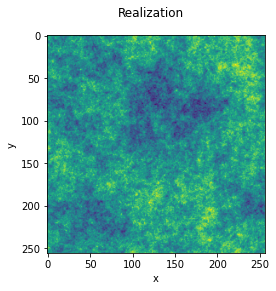

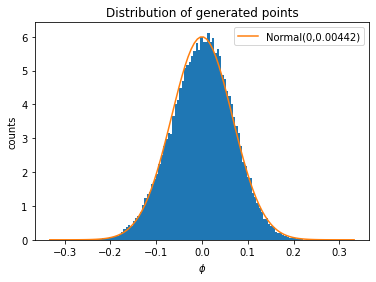

20% complete
40% complete
60% complete
80% complete
100% complete
Data collection time: 25.07046 seconds
Independent data pairs analyzed: 12103441


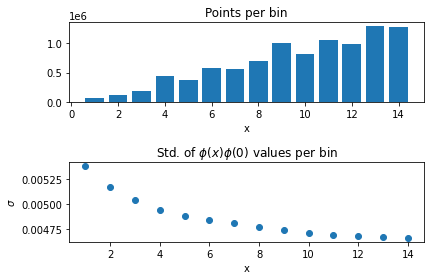

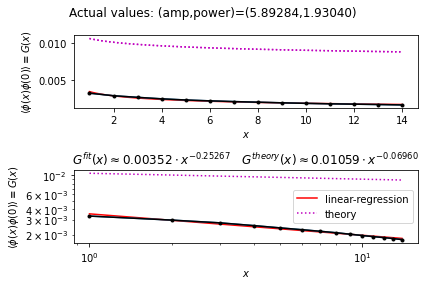

 61%|██████    | 3051/5000 [00:08<00:05, 372.05it/s]

In [ ]:
rand_amp, rand_power = np.random.uniform(0, 10,
                                         1)[0], np.random.uniform(.51, 1.99,
                                                                  1)[0]
print(f'amplitude: {rand_amp:.5f}', f'\npower: {rand_power:.5f}')

c = CmbPy(size_exponent=8, amplitude=rand_amp, power=rand_power)
c.generate()
c.spectrum_plot()
c.hist()
c.bin_pair_data(maxlen=15)
c.bayes(steps=5*10**3, walkers=64)